In [110]:
import tensorflow as tf 
from tensorflow.python.platform import gfile 
import os 
import cv2 
import torch 
from torchvision import datasets, models, transforms 
from torch.autograd import Variable 
import torch.nn as nn 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
from tqdm import tqdm_notebook 
from PIL import Image 
import numpy as np
from glob import glob
import math 
import resnet
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [111]:
def postprocess_boxes(pred_bbox, org_img_shape, input_size, score_threshold):
    valid_scale=[0, np.inf]
    
    pred_bbox = np.array(pred_bbox)
    #print (pred_bbox.shape)
    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]
    # # (1) (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # # (2) (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = org_img_shape
    resize_ratio = min(float(input_size) / org_w, float(input_size) / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # # (3) clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0
    

    # # (4) discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))
    #print np.where(scale_mask is True)

    # # (5) discard some boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    #print (np.max(scores))
    score_mask = scores > score_threshold
    #print np.sum(score_mask)
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)


def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        while len(cls_bboxes) > 0:
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes


def bboxes_iou(boxes1, boxes2):

    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

In [3]:
model_path = '/hdd/sd5/tlc/TCT/Model_pb/comb/res18_epoch=19_3channel.pb'
#val_path = '/ssd2/yuyue/TCT_data/TR_data/val/neg/TR_new_data/random_cut/'
test_path = glob("/hdd/sd5/tlc/TCT/all_data/YFY_20200305/data/val/neg/*")
model_ft = resnet.resnet18(pretrained =True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 2)
model_ft.load_state_dict(torch.load("/hdd/sd5/tlc/TCT/Model_pth/resnet18_3channel.pth"))
use_gpu = True
if use_gpu:
    model_ft = model_ft.cuda()

model_ft.eval()
for uid_path in test_path:
    count = 0
    for img_path in tqdm_notebook(glob(uid_path+'/*.jpg')):
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224*3, 224*2))
        except:
            continue

        img1 = img[0:224,0:224]
        img2 = img[0:224,224:224*2]
        img3 = img[0:224,224*2:224*3]
        img4 = img[224:224*2,0:224]
        img5 = img[224:224*2,224:224*2]
        img6 = img[224:224*2,224*2:224*3]
        img_list = [img1, img2, img3, img4, img5, img6]
        #ori_img = np.load(img_path)
        for ori_img in img_list:
            img_resize = Image.fromarray(ori_img)
#             img_resize = transforms.Resize((224, 416))(img_resize)
            image_input = transforms.ToTensor()(img_resize)
            image_input = image_input.unsqueeze(0)
            image_input = Variable(image_input.cuda())
            output, _ = model_ft(image_input)
            output = output[0][1].cpu().data.numpy()
            if output > 0.5:
                count += 1
    print count


4876



3130



6142



5511


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/miniconda3/envs/py2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/opt/miniconda3/envs/py2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/opt/miniconda3/envs/py2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/opt/miniconda3/envs/py2/lib/python2.7/inspect.py", line 1058, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/opt/miniconda3/envs/py2/lib/python2.7/inspect.py", line 1018, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/opt/miniconda3/envs/py2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader

IndexError: string index out of range

In [ ]:
model_path = '/hdd/sd5/tlc/TCT/Model_pb/comb/res18_epoch=16_3channel.pb'
#val_path = '/ssd2/yuyue/TCT_data/TR_data/val/neg/TR_new_data/random_cut/'
test_path = glob("/hdd/sd5/tlc/TCT/all_data/YFY_20200305/data/val/neg/*")
model_ft = resnet.resnet18(pretrained =True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 2)
model_ft.load_state_dict(torch.load("/hdd/sd5/tlc/TCT/Model_pth/"))
use_gpu = True
if use_gpu:
    model_ft = model_ft.cuda()

for uid_path in test_path:
    count = 0
    for img_path in tqdm_notebook(glob(uid_path+'/*.jpg')):
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224*3, 224*2))
        except:
            continue

        img1 = img[0:224,0:224]
        img2 = img[0:224,224:224*2]
        img3 = img[0:224,224*2:224*3]
        img4 = img[224:224*2,0:224]
        img5 = img[224:224*2,224:224*2]
        img6 = img[224:224*2,224*2:224*3]
        img_list = [img1, img2, img3, img4, img5, img6]
        #ori_img = np.load(img_path)
        for ori_img in img_list:
            img_resize = Image.fromarray(ori_img)
#             img_resize = transforms.Resize((224, 416))(img_resize)
            image_input = transforms.ToTensor()(img_resize)
            image_input = image_input.unsqueeze(0)
            image_input = Variable(image_input.cuda())
            output = model_ft(image_input)
            output = output[0][0][1].cpu().data.numpy()
            if output > 0.5:
                count += 1
    print count

In [4]:
model_path = '/hdd/sd5/tlc/TCT/Model_pb/comb/res18_epoch=16_3channel.pb'
#val_path = '/ssd2/yuyue/TCT_data/TR_data/val/neg/TR_new_data/random_cut/'
test_path = glob("/hdd/sd5/tlc/TCT/all_data/20190717/val/neg/*")
#test_path = glob("/ssd2/yuyue/TCT_data/ori_data/TR_data/测试/neg/*")
with tf.Graph().as_default() as graph:
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()
        with gfile.FastGFile(model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
            input_patch = sess.graph.get_tensor_by_name('input:0')
            output = sess.graph.get_tensor_by_name('fc_layer/op_to_store:0')
            cam = sess.graph.get_tensor_by_name('cam:0')
            trainable = sess.graph.get_tensor_by_name('trainable:0')
            for uid_path in test_path:
                count = 0
                for img_path in tqdm_notebook(glob(uid_path+'/*.jpg')):
                    try:
                        img = cv2.imread(img_path)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (224*3, 224*2))
                    except:
                        continue

                    img1 = img[0:224,0:224]
                    img2 = img[0:224,224:224*2]
                    img3 = img[0:224,224*2:224*3]
                    img4 = img[224:224*2,0:224]
                    img5 = img[224:224*2,224:224*2]
                    img6 = img[224:224*2,224*2:224*3]
                    img_list = [img1, img2, img3, img4, img5, img6]
                    #ori_img = np.load(img_path)
                    for ori_img in img_list:
                        ori_img = cv2.resize(ori_img, (224, 224))
                        im_norm = ori_img/255.
                        input_img = im_norm[np.newaxis, ...]
                        res, cam_res = sess.run([output, cam], feed_dict={input_patch:input_img, trainable:False})
                        if res[0][1] > 0.5:
                            count += 1
                            #print res[0][1]
#                             plt.imshow(ori_img)
#                             plt.show()
#                             plt.imshow(cv2.resize(cam_res[0], (224, 224)))
#                             plt.show()
                print count
             


437



798



199



124



111



60



856



655



70



120



132



198



318



752



535


In [2]:
model_path = '/hdd/sd5/tlc/TCT/Model_pb/comb/res18_epoch=19_1channel.pb'
#val_path = '/ssd2/yuyue/TCT_data/TR_data/val/neg/TR_new_data/random_cut/'
test_path = glob("/hdd/sd5/tlc/TCT/all_data/20190717/val/neg/*")
#test_path = glob("/ssd2/yuyue/TCT_data/ori_data/TR_data/测试/neg/*")
with tf.Graph().as_default() as graph:
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()
        with gfile.FastGFile(model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
            input_patch = sess.graph.get_tensor_by_name('input:0')
            output = sess.graph.get_tensor_by_name('fc_layer/op_to_store:0')
            cam = sess.graph.get_tensor_by_name('cam:0')
            trainable = sess.graph.get_tensor_by_name('trainable:0')
            for uid_path in test_path:
                count = 0
                for img_path in tqdm_notebook(glob(uid_path+'/*.jpg')):
                    try:
                        ori_img = cv2.imread(img_path)
                        image = np.zeros_like(ori_img)
                        img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
                        image[..., 0] = img
                        image[..., 1] = img
                        image[..., 2] = img
                        img = cv2.resize(image, (224*3, 224*2))
                    except:
                        continue

                    img1 = img[0:224,0:224]
                    img2 = img[0:224,224:224*2]
                    img3 = img[0:224,224*2:224*3]
                    img4 = img[224:224*2,0:224]
                    img5 = img[224:224*2,224:224*2]
                    img6 = img[224:224*2,224*2:224*3]
                    img_list = [img1, img2, img3, img4, img5, img6]
                    #ori_img = np.load(img_path)
                    for ori_img in img_list:
                        ori_img = cv2.resize(ori_img, (224, 224))
                        im_norm = ori_img/255.
                        input_img = im_norm[np.newaxis, ...]
                        res, cam_res = sess.run([output, cam], feed_dict={input_patch:input_img, trainable:False})
                        if res[0][1] > 0.5:
                            count += 1
                            #print res[0][1]
#                             plt.imshow(ori_img)
#                             plt.show()
#                             plt.imshow(cv2.resize(cam_res[0], (224, 224)))
#                             plt.show()
                print count

Instructions for updating:
Use tf.gfile.GFile.



423



1595



180



316



126



152



235



634



142



646



721



68



369



1049



206


In [4]:
image

NameError: name 'image' is not defined

In [134]:
model_path = '/hdd/sd5/tlc/TCT/Model_pb/ghm_loss/darknet53_test_loss=8.8437.pb'
#val_path = '/ssd2/yuyue/TCT_data/TR_data/val/neg/TR_new_data/random_cut/'
test_path = glob("/hdd/sd5/tlc/TCT/all_data/20190717/val/neg/*")
#test_path = glob("/ssd2/yuyue/TCT_data/ori_data/TR_data/测试/neg/*")
with tf.Graph().as_default() as graph:
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()
        with gfile.FastGFile(model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
            input_patch = sess.graph.get_tensor_by_name('input_data:0')
            pred_sbbox = sess.graph.get_tensor_by_name('pred_sbbox/op_to_store:0')
            pred_mbbox = sess.graph.get_tensor_by_name('pred_mbbox/op_to_store:0')
            pred_lbbox = sess.graph.get_tensor_by_name('pred_lbbox/op_to_store:0')            
            trainable = sess.graph.get_tensor_by_name('training:0')
            img_list_ = []
            for uid_path in test_path:
                bbox_count = 0
                for img_path in tqdm_notebook(glob(uid_path+'/*.jpg')):
                    img = cv2.imread(img_path)
                    if np.var(img) < 100:
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224*3, 224*2))
                    img1 = img[0:224,0:224]
                    img2 = img[0:224,224:224*2]
                    img3 = img[0:224,224*2:224*3]
                    img4 = img[224:224*2,0:224]
                    img5 = img[224:224*2,224:224*2]
                    img6 = img[224:224*2,224*2:224*3]
                    img_list = [img1, img2, img3, img4, img5, img6]
                    #ori_img = np.load(img_path)
                    for ori_img in img_list:
                        #ori_img = cv2.resize(ori_img, (224, 224))
                        im_norm = ori_img/255.
                        input_img = im_norm[np.newaxis, ...]
                        ret_sbbox, ret_mbbox, ret_lbbox = sess.run([pred_sbbox, pred_mbbox, pred_lbbox], feed_dict={input_patch:input_img, trainable:False})
                        pred_bbox = np.concatenate([np.reshape(ret_sbbox, (-1, 5 + 2)),
                                    np.reshape(ret_mbbox, (-1, 5 + 2)),
                                     np.reshape(ret_lbbox, (-1, 5 + 2))], axis=0)
                        bboxes = postprocess_boxes(pred_bbox, (224, 224), 224, 0.2)
                        bboxes = nms(bboxes, 0.3)
                        bbox_count += len(bboxes)
                        for bbox in bboxes:
                            xmin = int(bbox[0])
                            ymin = int(bbox[1])
                            xmax = int(bbox[2])
                            ymax = int(bbox[3])
                            if int(bbox[5]) == 0:
                                cv2.rectangle(ori_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                            elif int(bbox[5]) == 1:
                                cv2.rectangle(ori_img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
                            img_list_.append(ori_img)
#                         if len(bboxes) > 0:
#                             plt.figure(figsize=(7,7))
#                             plt.imshow(ori_img)
#                             plt.show()
                print bbox_count
                            
             


1262046


KeyboardInterrupt: 

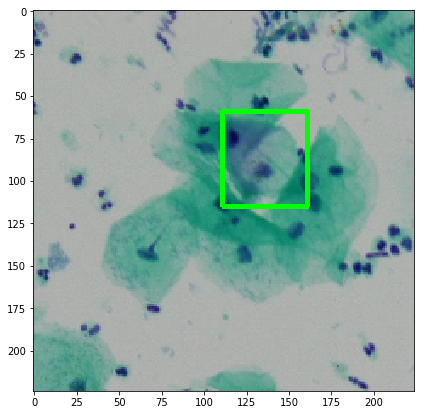

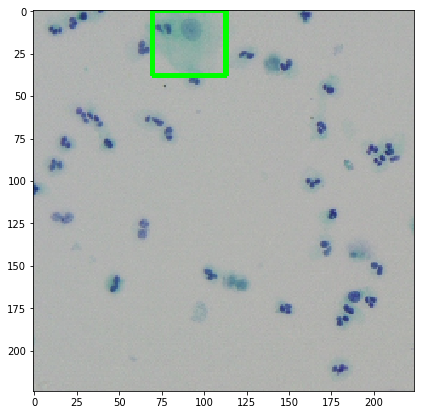

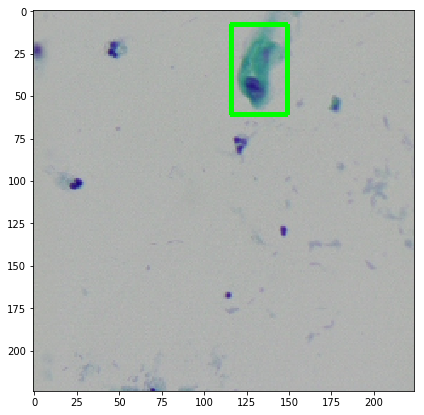

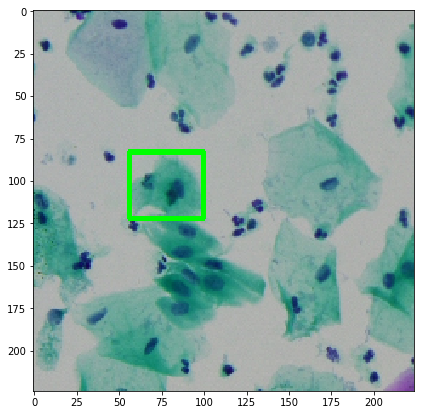

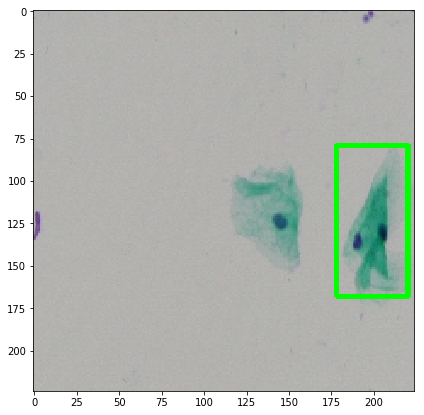

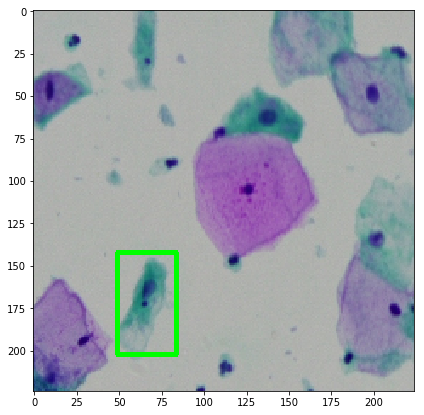

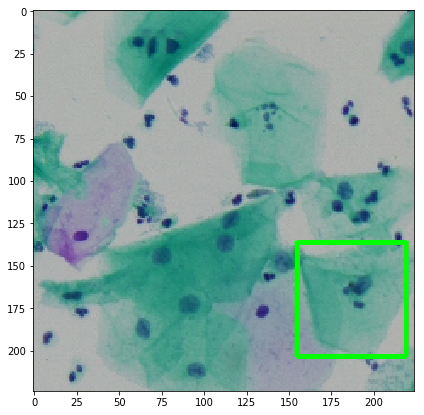

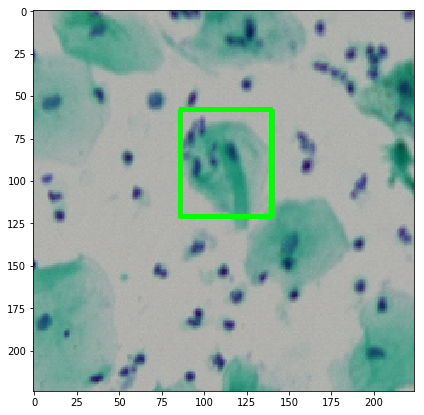

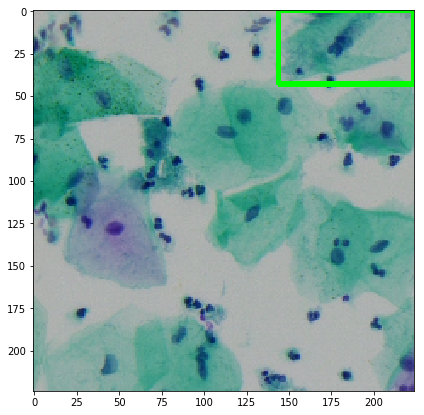

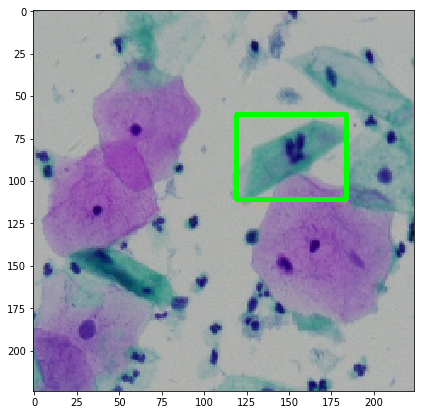

In [133]:
import random
for img in random.sample(img_list_, 10):
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.show()

In [71]:
anno = []
with open('/home/yuyue/yuyue/yolo_TCT/tensorflow-yolov3-multilabel/cut_6_patch_yolo/train_0817_三分类.txt' , 'r') as f:
    lines = f.readlines()
    for line in lines:
        anno.append(line)
    

/ssd2/yuyue/TCT_data/20200701_data/train/pos/ASC-H/cluster/QL_270_data/21f6ad65221f51a69276b725fe91669ea6217998_000194_4_random.npy 100,15,124,70,1



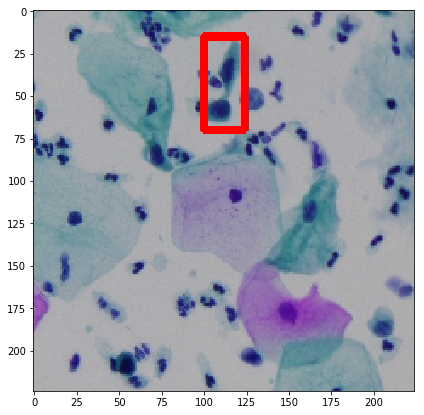

/ssd2/yuyue/TCT_data/20200701_data/train/pos/ASC-US/individual/TR_data/711f721b7a5eeea6da8f1c2c62c4c11fd4280831_002434_5_6cut.npy 110,190,160,224,0



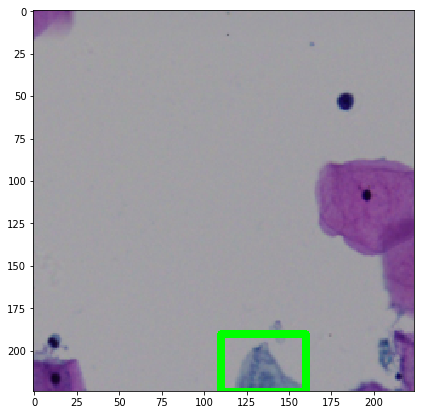

/ssd2/yuyue/TCT_data/20200701_data/train/neg/阳性slide中的阴性/other/TR_data/2012b003c26d0e65ff887f8ff76ccce70fd6aed1_000431_6cut.npy 0,0,0,0,2



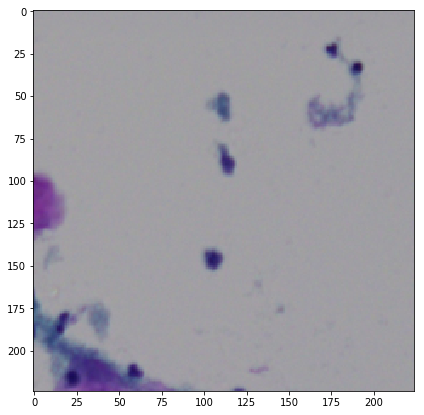

/ssd2/yuyue/TCT_大图/20200805_data/train/neg/hard_neg/other/QL_data/588962e63b2643ddcaac4960b33bed9185c68e35_47085_27968.npy 0,0,0,0,2



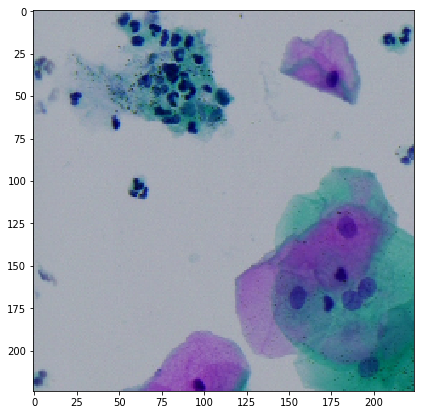

/ssd2/yuyue/TCT_data/20200701_data/train/neg/hard_neg/other/YFY_2_data/a0adbcf505407862f440dded0fe1639834f24555_000235_2.npy 0,0,0,0,2



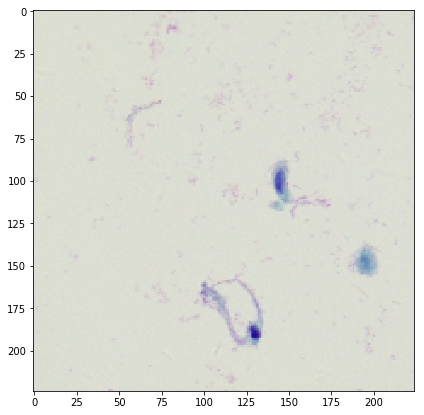

/ssd2/yuyue/TCT_大图/20200805_data/train/pos/AGC-NOS/individual/QL_500_data/95b6bc391594a8bff4be8f559aedd346c1e42134_22496_5247.npy 97,112,174,179,1



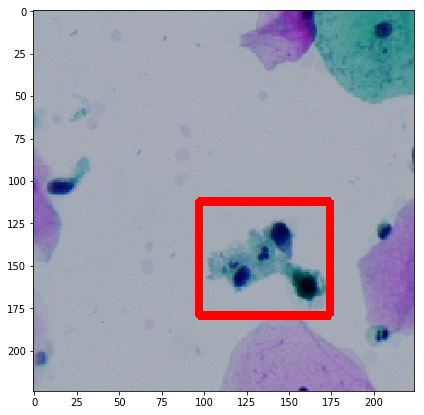

/ssd2/yuyue/TCT_data/20200701_data/train/neg/子宫颈管腺细胞/cluster/QL_270_data/35cd8e291597781653f877c6adcd10773ad767c2_000510_4_6cut.npy 0,0,0,0,2



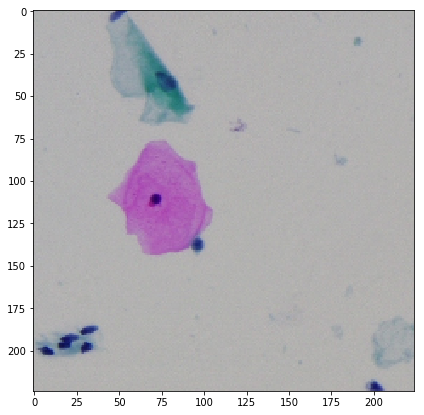

/ssd2/yuyue/TCT_data/20200701_data/train/pos/ASC-US/individual/QL_0327_data/bd044782e5327e3fe0342c88110667fc666cb216_000566_2_random.npy 80,167,137,218,0



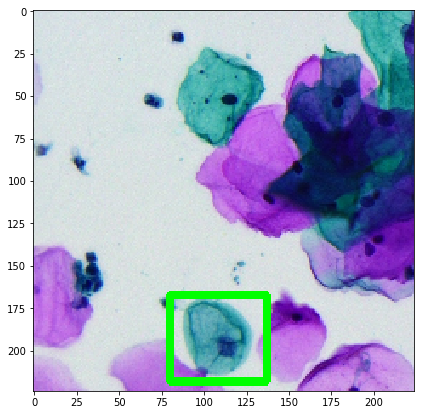

/ssd2/yuyue/TCT_大图/20200805_data/train/pos/ASC-US/individual/CH_data/fcd2123801529c4b5c8c7ba7f70b4a528df0b6c0_16399_28809.npy 68,73,141,123,0



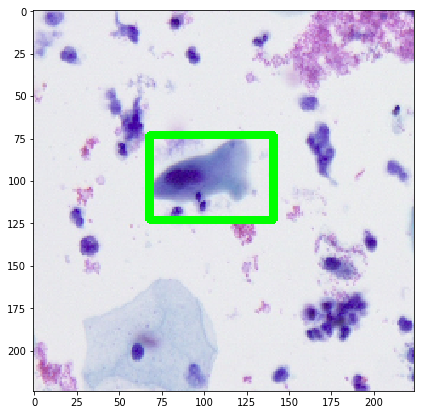

/ssd2/yuyue/TCT_data/20200701_data/train/pos/HSIL/cluster/TR_data/6fa3606841039c3b7c2b2709fa654eb95d06863d_001852_3_random.npy 162,163,214,217,1



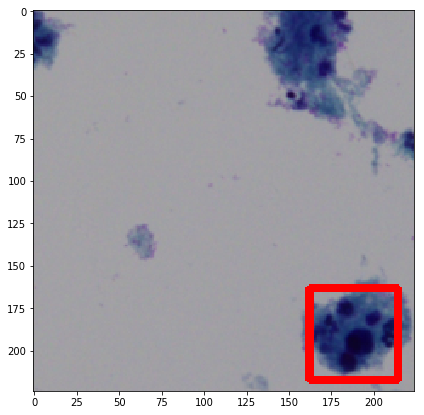

In [108]:
for line in random.sample(anno, 10):
    img_path = line.split(' ')[0]
    bboxes = line.split(' ')[1:]
    img = np.load(img_path)
    for bbox in bboxes:
        coords = bbox.split(',')
        xmin, ymin, xmax, ymax, type = int(coords[0]), int(coords[1]), int(coords[2]), int(coords[3]), int(coords[4]) 
        if type == 0:
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        elif type == 1:
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
    print line
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.show()